# Part 1: Scraping One Page

#### 1) Used libraries

In [1]:
import re # making regular expression
import pandas as pd # reading and processing data
from nltk.tokenize import word_tokenize  # tokenize text
from nltk.corpus import stopwords # removing stopwords
from collections import Counter # counting the frequency of words
import matplotlib.pyplot as plt # plotting
import requests # request html content
from bs4 import BeautifulSoup # handle html content, e.g. searching
from multiprocessing.pool import ThreadPool # used for processing articles using threads
import os # used for check how many cores the PC have
from tqdm import tqdm # showing progress
import numpy as np

#### 2) Retrieve document

In [2]:
# Get the content:
url = 'https://www.bbc.com/news'
repsonse = requests.get(url)
content = repsonse.text

I am searching for the following news title

![news_title_to_find](news_title_to_find.png)

In [3]:
news_title_to_find = 'Power, privilege and murder - the downfall of a dynasty'

In [4]:
# Try to find the news title of interest:
start_index = content.find(news_title_to_find)
if start_index>0:
    print(f"News title:\n   {content[start_index:start_index+len(news_title_to_find)]}\nIS FOUND!")
else:
    print("News title NOT found")

News title NOT found


<ins>Comment</ins>:<br />
We are able to find the news title within the raw content just by using the standard string find() method. This method are returning the start index of the found title (if no found -1 is returned). This start index is then used to extract the whole title.

#### 3) Find news title within content ("manually" using Regular Expressions)

After inspecting the content of some news titles, we have found that the titles occurs in a h3-tag, therefore:

In [5]:
# Regular expression to extract news titles:
h3_regex = r'<h3 .*?">(.+?)<\/h3>'

# Extract news titles:
news_titles = re.findall(h3_regex, content)

# Remove duplicates:
news_titles = list(set(news_titles)) 

# Print all news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 39

News titles:

Manchester bomber friend known to MI5, BBC reveals
Fox hosts endorsed false election claims - Murdoch
Zelensky says situation in frontline city worsening
How to relax like a Greenlander
The tiny diamond sphere that could unlock clean power
The loneliest villages in England
NZ beat England by one run in all-time great finish
Opposition boycott Nigeria election announcement
Why siblings are becoming less common
Guilt-free flying not in easy reach - scientists
Mobile app
Can clothes ever be fully recycled?
The original male model
Israeli-American killed in West Bank amid unrest
DeSantis warns &#x27;buckle up&#x27; as he gets Disney power
What to know about the Alex Murdaugh murder trial
&#x27;The only black female in Kharkiv, Ukraine&#x27;
Cold snap leaves Barcelona covered in snow
Final stamps bearing the Queen&#x27;s head revealed
Northern Ireland Brexit deal: At-a-glance
More than 100 deaths feared in shipwreck off Italy
BBC World News TV
New Yo

<ins>Comment</ins>:<br />
Some difficulities using regular expressions for this task is could be that the HTML structure can vary in its structure and especially when it comes to nested tags, special characters, and comments. To compensate for this complex regular expressions is needed for handling all scenarious. Also when changes are done in the HTML structure, then changes to the regular expressions are also needed. In addition to that dynamic content is also (nerely impossible) to handle with regular expressions e.g. content generated by JavaScript. But for this task of course this is not an issue.
 
Following issues is detected from the above printout:
 - Format issue: Apostrophes is not converted correctly.
 - Some additional header-titles are included, e.g. "Mobile app" and "Get in touch". By inspecting the source code in Web Developer Tools, I found that each news titles is having the same class attached. Therefore, we can filter the content based on that conclusion.

These two issues can be fixed, with the following changes to the code:

In [6]:
# Extract only news titles, not other titles:
h3_regex = r'<h3 class="gs-c-promo-heading__title .+?">(.+?)<\/h3>'

# Extract news titles:
news_titles = re.findall(h3_regex, content)

# Remove duplicates by converting to a set and back to list again:
news_titles = list(set(news_titles))

# Fix apostrophes:
news_titles = [item for item in map(lambda x: re.sub(r'(&#x27;)', "'", x), news_titles)]

# Print news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 36

News titles:

Manchester bomber friend known to MI5, BBC reveals
Fox hosts endorsed false election claims - Murdoch
Zelensky says situation in frontline city worsening
How to relax like a Greenlander
The tiny diamond sphere that could unlock clean power
The loneliest villages in England
NZ beat England by one run in all-time great finish
Opposition boycott Nigeria election announcement
Why siblings are becoming less common
Guilt-free flying not in easy reach - scientists
Can clothes ever be fully recycled?
The original male model
Israeli-American killed in West Bank amid unrest
DeSantis warns 'buckle up' as he gets Disney power
What to know about the Alex Murdaugh murder trial
'The only black female in Kharkiv, Ukraine'
Cold snap leaves Barcelona covered in snow
Final stamps bearing the Queen's head revealed
Northern Ireland Brexit deal: At-a-glance
More than 100 deaths feared in shipwreck off Italy
BBC World News TV
New York City struggles with migrant influ

<ins>Comment</ins>:<br />
After we have done filter out titles that are not at interest and done some replacements for apostrophes, we have the correct titles as in the webpage.

#### 4 & 5) Extract all news titles ("automatically" using BeautifulSoup)

We know from the previous task that the titles of interest is having the class 'gs-c-promo-heading__title'.

In [7]:
soup = BeautifulSoup(repsonse.content, 'html.parser')

# Extract news titles:
news_titles = [title.text for title in soup.find_all('h3', class_='gs-c-promo-heading__title')]

# Remove duplicates:
news_titles = list(set(news_titles))

# Print news titles:
print(f"Number of news titles: {len(news_titles)}\n\nNews titles:\n")
print(*news_titles, sep="\n")

Number of news titles: 36

News titles:

Manchester bomber friend known to MI5, BBC reveals
Fox hosts endorsed false election claims - Murdoch
Zelensky says situation in frontline city worsening
How to relax like a Greenlander
The tiny diamond sphere that could unlock clean power
The loneliest villages in England
NZ beat England by one run in all-time great finish
Opposition boycott Nigeria election announcement
Why siblings are becoming less common
Guilt-free flying not in easy reach - scientists
Can clothes ever be fully recycled?
The original male model
Israeli-American killed in West Bank amid unrest
Hawara: 'What happened was horrific and barbaric'
What to know about the Alex Murdaugh murder trial
Cold snap leaves Barcelona covered in snow
Northern Ireland Brexit deal: At-a-glance
More than 100 deaths feared in shipwreck off Italy
Final stamps bearing the Queen's head revealed
BBC World News TV
New York City struggles with migrant influx
DeSantis warns 'buckle up' as he gets Disne

<ins>Comment</ins>:<br />
Nice! We are getting the same number of news as the "manually" method.
Notice that we are not having apostrophes issues with this library.

#### 6) Extract only top stories

In [8]:
# Get only top stories:
top_stories = [story.find('h3', class_='gs-c-promo-heading__title').text for story in soup.find('div', class_='nw-c-top-stories--standard').find_all('div', class_='gs-c-promo-body')]

# Remove duplicates:
top_stories = list(set(top_stories))

# Print news titles:
print(f"Number of news titles: {len(top_stories)}\n\nNews titles:\n")
print(*top_stories, sep="\n")

Number of news titles: 14

News titles:

Manchester bomber friend known to MI5, BBC reveals
Missing Levi case probed by Spanish crime unit
Cold snap leaves Barcelona covered in snow
Fox hosts endorsed false election claims - Murdoch
China should be honest on Covid origin, says US envoy
Zelensky says situation in frontline city worsening
More than 100 deaths feared in shipwreck off Italy
Canada bans TikTok on government devices
Guilt-free flying not in easy reach - scientists
DeSantis warns 'buckle up' as he gets Disney power
Israeli-American killed in West Bank amid unrest
NZ beat England by one run in all-time great finish
Opposition boycott Nigeria election announcement
UK's Sunak in Belfast after reaching new Brexit deal


<ins>Comment</ins>:<br />
We are now correctly only getting top stories.

#### 7) Extract summmaries of the news title and section it belongs to

In [9]:
# Find top stories:
top_stories = soup.find('div', class_='nw-c-top-stories').find_all('div', class_='gs-c-promo-body')

# Extract title, summary, and section for each top story:
top_stories = [{'title': item.find('h3', class_='gs-c-promo-heading__title').text,'summary': item.find('p', class_='gs-c-promo-summary').text,'section': item.find('a', class_='gs-c-section-link').text} for item in top_stories]

# Remove duplicates based on title
unique_top_stories = []
unique_titles = set() # set for checking if story is already found
for story in top_stories:
    if story['title'] not in unique_titles:
        unique_top_stories.append(story)
        unique_titles.add(story['title'])

print(f"Number of news titles: {len(unique_top_stories)}\n")
df = pd.DataFrame(unique_top_stories)
df

Number of news titles: 14



,title,summary,section
0,UK's Sunak in Belfast after reaching new Brexi...,Rishi Sunak set to face tough questions in Nor...,UK
1,Zelensky says situation in frontline city wors...,Russian forces have been trying to capture the...,Europe
2,"Manchester bomber friend known to MI5, BBC rev...",A man who was close to Salman Abedi had been i...,UK
3,Missing Levi case probed by Spanish crime unit,Police in Barcelona say the rugby player's cas...,Newsbeat
4,Fox hosts endorsed false election claims - Mur...,The billionaire's acknowledgement is revealed ...,US & Canada
5,Cold snap leaves Barcelona covered in snow,Storm Juliette sets off a weather alert in par...,Europe
6,Israeli-American killed in West Bank amid unrest,The shooting happened after Israeli settlers a...,Middle East
7,More than 100 deaths feared in shipwreck off I...,Prime Minister Giorgia Meloni urges EU institu...,Europe
8,"China should be honest on Covid origin, says U...",Beijing hits back that the outbreak's origin i...,US & Canada
9,DeSantis warns 'buckle up' as he gets Disney p...,Walt Disney World's self-governing district is...,US & Canada


<ins>Comment</ins>:<br />
We are now correctly getting the summary for each top story and their corresponding section.

#### 8) Write news titles to csv file

In [10]:
# Save the dataframe to csv:
df.to_csv('bbc-news.csv', index=False)

# Part 2: Scraping a Reliable News Dataset

Extract all articles from "https://en.wikinews.org/wiki/Category:Politics_and_conflicts", with starting letters:

In [11]:
group_nr = 2
expression = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[group_nr%23:group_nr%23+10]
expression = [*expression]
print("Letters to search for:")
print(*expression, sep=', ')

Letters to search for:
C, D, E, F, G, H, I, J, K, L


<ins>Comment</ins>:<br />
All articles with the letters printed out above should now be found:

In [12]:
base_url = 'https://en.wikinews.org'
nxt_url = base_url + '/wiki/Category:Politics_and_conflicts'

start_letter = expression[0]
# Get the letter after the last letter to search for
to_letter = chr(ord(expression[-1]) + 1)

# Get all links for the start letters to search for
items = []
i = 0
current_letter = ""
while current_letter <= expression[-1]:
    response = requests.get(nxt_url)
    content = response.content
    soup = BeautifulSoup(content, "html.parser")
    page = soup.find("div", {"id": "mw-pages"})
    nxt_url = base_url + page.find("a", string='next page').get('href')
    categories = page.findAll("div", {"class": "mw-category-group"})
    for category in categories:
        current_letter = category.find("h3").text
        if current_letter > expression[-1]:
            break
        if current_letter >= start_letter:
            urls = category.findAll("a")
            for url in urls:
                i=i+1
                print(f"Working on letter: {current_letter}; Item: {i}", end="\r")
                url = base_url + url.get('href')
                items.append([current_letter, url])

print("\n\nFinished!")

Working on letter: L; Item: 2683

Finished!


In [13]:
# Function to remove remove commas, multiple tabs, multiple newlines, multiple spaces and special characters::
def clean_text(text):
    # List of patterns and their appropriate replacements:
    patterns = {
        r'\t+': ' \t ',
        r'\n+': ' \n ',
        r'\s{2,}': ' ',
        r'\(|\)|\`|\'|\´|\"|\,|\!|\[|\]|\.|\?|\–|\&|\—|\”|\“|\%|\:|\;|\-': '',
    }
    
    # Lowercase all characters:
    text = text.lower()
    
    # Loop through each pattern and apply the pattern to each column and do replacement if needed:
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, str(text))

    return text

In [16]:
# Function to process the article link.
# Returning the start-letter, title, url, date and content
def process_item(item):
    current_letter, url = item
    
    # Get content:
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, "html.parser")
    
    # Get title:
    title = soup.find("span", {"class": "mw-page-title-main"})
    title = title.get_text() if title else ''
    
    # Get article:
    article = soup.find("div", {"class": "mw-parser-output"})
    
    # Get date:
    if article:
        date = article.find('span', {"id": "publishDate"})
        if date:
            date = date.get('title')
        else:
            date = ''
    
    # Get text, combine it and clean it:
    text = article.findAll("p", recursive=False)
    text = ''.join(p.get_text() for p in text)
    text = clean_text(text)
    
    # Add articles to list:
    return [current_letter, title, url, date, text]

In [17]:
articles = []
# Create a thread pool by the size of CPU-cores x 2 (rule of thumb) for processing articles:
with ThreadPool(os.cpu_count()*2) as pool:
    # Use tqdm to show progress:
    # with imap ordering is kept and results can be received immediately
    for article in tqdm(pool.imap(process_item, items), total=len(items)):
        articles.append(article)

100%|██████████████████████████████████████████████████████████████████████████████| 2683/2683 [01:32<00:00, 28.94it/s]


In [18]:
# Save the list to pandas dataframe:
df = pd.DataFrame(articles, columns=['letter', 'title', 'url', 'date', 'content'])

# Convert date column to panda date:
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# Remove the date at the beginning of the content using regex:
pattern = r'^(.+? .+? \d{1,2} \d{4}.?)'
df['content'] = df[['content']].applymap(lambda x: re.sub(pattern, '', x))

# Print the dataframe:
df

,letter,title,url,date,content
0,C,Cabinet Minister resigns after boycott in Grenada,https://en.wikinews.org/wiki/Cabinet_Minister_...,2010-11-23,a grenadian cabinet minister has resigned afte...
1,C,Cabinet shuffled in Ontario,https://en.wikinews.org/wiki/Cabinet_shuffled_...,2006-09-19,ontario premier dalton mcguinty implemented a ...
2,C,Cabinet to discuss UK nuclear deterrent for th...,https://en.wikinews.org/wiki/Cabinet_to_discus...,2006-11-22,the labour partys 2005 election manifesto read...
3,C,CAFTA faces tough vote in U.S. House,https://en.wikinews.org/wiki/CAFTA_faces_tough...,2005-07-27,president bush is lobbying the us house of rep...
4,C,Cairo blast kills 3,https://en.wikinews.org/wiki/Cairo_blast_kills_3,NaN,april 8 2005 visitors to popular tourist spots...
...,...,...,...,...,...
2678,L,Lula's future in the hands of Brazilian Parlia...,https://en.wikinews.org/wiki/Lula%27s_future_i...,2005-06-12,the government of brazilian president luiz iná...
2679,L,"Lula: Venezuela ""does not lack democracy""",https://en.wikinews.org/wiki/Lula:_Venezuela_%...,2007-11-18,in statements to the press on november 14 the ...
2680,L,Luxembourg head of government resigns after ei...,https://en.wikinews.org/wiki/Luxembourg_head_o...,2013-07-13,prime minister jeanclaude juncker of the grand...
2681,L,Luxembourg votes Yes to the EU treaty,https://en.wikinews.org/wiki/Luxembourg_votes_...,2005-07-10,the people of luxembourg voted a slight yes to...


In [19]:
# Save the dataframe to csv:
df.to_csv('wiki.csv', index=False)

<ins>Comment</ins>:<br/>
With the above code we are able to get the title, url, date and the content of the articles using threads. ThreadPool is suitable for I/O-bound tasks that involve waiting for I/O operations, such as network requests or file I/O, which indeed is the case here. By using threads we can improve the performance by allowing other tasks to be executed while waiting. Threads are chosen instead of Pool (multiprocessing/cores), since the bottle-neck here is the amount network requests not the amount of CPU-power.

##### Statistics:
 - Year with most articles
 - Most frequent words
 - Average number of words in the articles

##### Year with most articles:

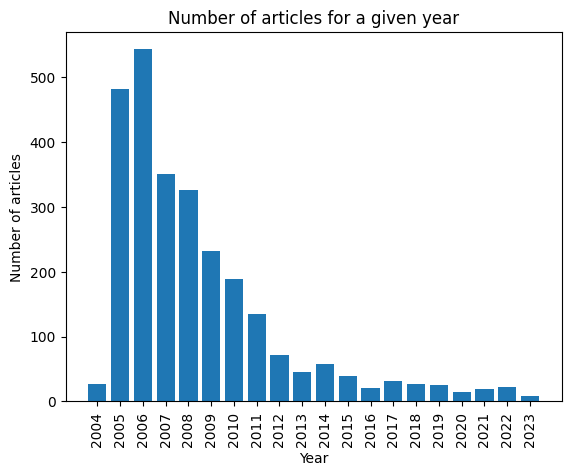

In [20]:
# Extract the year from each date:
year_counts = pd.to_datetime(df['date']).dropna().dt.year.value_counts() # dropna(): dropping empty values

# Plot the year frequency distribution
plt.bar(year_counts.index, year_counts.values)
plt.xticks(year_counts.index, rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles for a given year')
plt.show()

<ins>Comment</ins>:<br/>
From the above we can see that a lot of articles was made in the years 2005-2008(10).
This could be that between 2005 and 2008, there were several notable political events and conflicts, such as the Iraq War, the election of Barack Obama as the President, and the global financial crisis. As a result, it is likely that many news articles were written about these events during that time period and subsequently added to Wikinews.

##### Most frequent words:

In [21]:
def remove_stopwords(words):
    # Remove stopwords
    stop_words = stopwords.words("english")
    
    # Loop through all elements and remove stopwords
    return [word for word in words if word not in stop_words]  # Remove stopwords from the list

In [22]:
def count_word_frequency(words):
    # Create a Counter list
    frequency = Counter()
    
    # Update/add list of words
    frequency.update(words)
    
    # Return the sorted dictionary based on the frequency of each word
    return sorted(frequency.items(), key=lambda x: x[1], reverse=True)

In [23]:
def plot_word_frequency(sorted_frequency):
    # Number of words to list of frequency
    nwords = 50

    # Extract the words and their frequency from the sorted list
    words = [x[0] for x in sorted_frequency[:nwords]]
    frequency = [x[1] for x in sorted_frequency[:nwords]]

    # Plot a barplot using matplotlib
    plt.bar(words, frequency)
    plt.ylabel('Frequency')
    plt.title('Frequency of the 50 most frequent words')
    plt.xticks(rotation=90)
    plt.show()

In [24]:
# Get the content a join them together:
contents = df["content"].tolist()
contents = "".join(contents)

# Create a list of words
tokens = word_tokenize(contents)

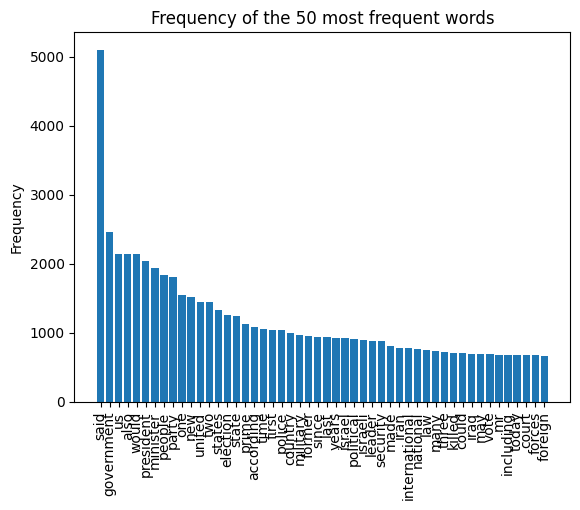

In [25]:
# Remove stopwords
words = remove_stopwords(tokens)
# Count the frequency of each word:
word_frequency = count_word_frequency(words)
# Plot the frequency of words
plot_word_frequency(word_frequency)

<ins>Comment</ins>:<br/>
From the above we can see the most frequent words are in a political tone. 

##### Average number of words in the articles:

Average number of words: 319
Number of outliers: 146, from a total of 2683 articles


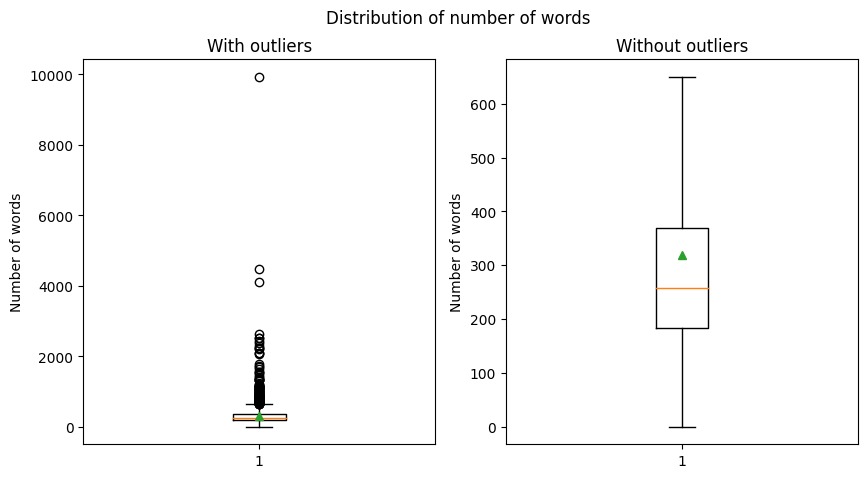

In [32]:
# Split the column into a list of words and then calculate the number of words:
word_count = df['content'].str.split().apply(len)

# Calculate the average number of words:
average_word_count = word_count.mean()

print(f"Average number of words: {int(average_word_count)}")

# Generate a box plot of the word counts:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

box_plot_data = ax1.boxplot(word_count, showfliers=True, showmeans=True)
ax1.set_title('With outliers')
ax1.set_ylabel('Number of words')

# Count outliers
outliers = [point for point in box_plot_data['fliers'][0].get_ydata()]
outlier_count = len(outliers)
print(f"Number of outliers: {outlier_count}, from a total of {len(articles)} articles")

ax2.boxplot(word_count, showfliers=False, showmeans=True)
ax2.set_title('Without outliers')
ax2.set_ylabel('Number of words')

# Show the plot:
fig.suptitle('Distribution of number of words')
plt.show()

<ins>Comment</ins>:<br />
From the above we can see that the main part of the articles contains between ~200 to ~400 words if we remove the 146 outliers from a total of 2683 articles.